# Нейронные сети и transfer learning

При обучении глубокой и прокаченной нейросети на собственном наборе данных мы, скорее всего, увидим, что качество нас не устраивает. К сожалению, обучение нейросети с нуля на не очень большой выборке часто приводит к переобучению, что плохо сказывается на тестовом качестве. Для того, чтобы получить более качественную модель, часто **до**обучают сильную нейросеть, обученную на [ImageNet](http://www.image-net.org/), то есть используют технику Transfer Learning. 

В PyTorch уже есть такие модели: https://pytorch.org/docs/stable/torchvision/models.html. Например, для классификации:

* AlexNet
* VGG
* ResNet
* SqueezeNet
* DenseNet
* Inception v3
* GoogLeNet
* ShuffleNet v2
* MobileNet v2
* ResNeXt
* Wide ResNet
* MNASNet

В Keras тоже есть различные модели: https://keras.io/api/applications/

## CIFAR10



**CIFAR-10** - одна из стандартных задач классификации картинок.

Датасет содержит $60000$ цветных фото объектов $10$ классов размером $32\text{x}32$ пикселей.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png" width="500">



### Пререквизиты
Загрузим необходимые библиотеки

In [ ]:
%tensorflow_version 1.x
# Импортируем сам keras
import keras
# Последовательный тип модели
from keras.models import Sequential
# Импортируем полносвязный слой, слои активации и слой, превращающий картинку в вектор
from keras.layers import Dense, Activation, Flatten
# Импортируем сверточный слой, max-пулинг слой и слой, выключающий часть нейронов
from keras.layers import Conv2D, MaxPooling2D, Dropout

# Импортируем датасеты
import keras.datasets

import numpy as np
from matplotlib import pyplot as plt

# Эти библиотеки отключают лишние предупреждения от библиотек, в частности,
# tensorflow, чтобы не засорять вывод наших результатов
import warnings
warnings.filterwarnings("ignore")

# keras является оболочкой для более низкоуровневых библиотек, 
# в нашем случае мы используем tensorflow, у которого на данный момент 
# поддерживаются две версии, установим первую
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

TensorFlow 1.x selected.


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


### Utils

Здесь некоторые дополнительные функции, которые облегчат нам работу с данными (в основном для вывода изображений).

In [ ]:
def plot_dataset_samples_grid(image_data, dataset_name='', N=8):
  """
    Эта функция строит NxN сэмплов из датасета image_data

    Параметры
    ----------
    image_data : array
        Array of shape 
        (number_of_samples, image_width, image_height, number of channels)
        with images
    dataset_name : str
        Name of dataset to write in the title
    N : int
        Size of grid of samples 
  """
  plt.figure(figsize=(10,10))
  data1=image_data[:N*N]
  
  image_width=image_data.shape[1]
  image_heigth=image_data.shape[2]

  if len(data1.shape)==4:
    image_channels=image_data.shape[3]
    data1 = data1.reshape(N, N,image_width,image_heigth, image_channels)
    data1 = np.transpose(data1,(0,2,1,3,4))
    data1 = data1.reshape(N*image_width,N*image_heigth,image_channels)
    plt.imshow(data1)

  elif len(data1.shape)==3:
    data1 = data1.reshape(N, N,image_width,image_heigth)
    data1 = np.transpose(data1,(0,2,1,3))
    data1 = data1.reshape(N*image_width,N*image_heigth)
    plt.imshow(data1,cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title('First '+ str(N*N) + ' '+dataset_name+ ' samples of training set')
  plt.show()

def plot_CIFAR_samples(image_data, label_data, classes,  N=8):
  """
    Эта функция строит N сэмплов каждого класса из датасета image_data

    Параметры
    ----------
    image_data : array
        Array of shape 
        (number_of_samples, image_width, image_height, number of channels)
        with images
    label_data : array
        Array of shape 
        (number_of_samples, )
        with labels
    classes : dict
        Dictionary {class_number:class_name}
    dataset_name : str
        Name of dataset to write in the title
    N : int
        Number of samples for each class 
  """
  plt.figure(figsize=(10,N))
  num_classes = len(classes.keys())
  for i,key in enumerate(classes.keys()):
      idxs = np.flatnonzero(label_data == key)
      idxs = np.random.choice(idxs, N, replace=False)
      for i, idx in enumerate(idxs):
          plt_idx = i * num_classes + key + 1
          plt.subplot(N, num_classes, plt_idx)
          plt.imshow(image_data[idx].astype('uint8'))
          plt.axis('off')
          if i == 0:
              plt.title(classes[key])
  plt.show()

from os import listdir, sep
from os.path import abspath, basename, isdir
def tree(dir, padding= '  ', print_files=False):
    """
    Эта функция строит дерево поддиректорий и файлов для заданной директории

    Параметры
    ----------
    dir : str
        Path to needed directory
    padding : str
        String that will be placed in print for separating files levels
    print_files : bool
        "Print or not to print" flag
    """
    cmd = "find '%s'" % dir
    files = os.popen(cmd).read().strip().split('\n')
    padding = '|  '
    for file in files:
        level = file.count(os.sep)
        pieces = file.split(os.sep)
        symbol = {0:'', 1:'/'}[isdir(file)]
        if not print_files and symbol != '/':
            continue
        print (padding*level + pieces[-1] + symbol)

def plot_cats_dogs_samples(train_dir, N=4):
  """
    Эта функция строит N самплов каждого класса из датасета Cats vs Dogs

    Параметры
    ----------
    train_dir : str
        Directory with train Cats vs Dogs dataset
    N : int
        Number of samples for each class 
  """
  import random
  fig, ax = plt.subplots(2,N,figsize=(5*N,5*2))

  for i,name in enumerate(['cat','dog']):
    filenames = os.listdir(os.path.join(train_dir,name))
    
    for j in range(N):
      sample = random.choice(filenames)
      image = load_img(os.path.join(train_dir,name,sample))
      ax[i][j].imshow(image)
      ax[i][j].set_xticks([])
      ax[i][j].set_yticks([])
      ax[i][j].set_title(name)
  plt.grid(False)
  plt.show()

def load_special_images():
  """
    Эта функция загружает 3 картинки для темы бинарной классификации кошек
    и собак

    Returns
    ----------
    im1, im2, im3 : array
        Three images in a form of numpy array
  """
  import requests
  from PIL import Image
  
  image_url_1 = 'https://preview.redd.it/4j8gx4ztzex01.png?width=960&crop=smart&auto=webp&s=5e80ab0071d56cc042f7b709648de8cde394832a'
  image_url_2 = 'https://cdn.images.express.co.uk/img/dynamic/128/590x/secondary/Viral-cat-sensation-715546.jpg'
  image_url_3 = 'https://www.sunnyskyz.com/uploads/2016/12/hmm9j-dog-or-cat-2.jpg'

  im1 = Image.open(requests.get(image_url_1, stream=True).raw)
  im1 = np.array(im1)
  im2 = Image.open(requests.get(image_url_2, stream=True).raw)
  im2 = np.array(im2)
  im3 = Image.open(requests.get(image_url_3, stream=True).raw)
  im3 = np.array(im3)

  return im1, im2, im3

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ 
    Эта функция показывает 6 картинок с предсказанными и настоящими классами
    """
    label_dict={0.:'cat',1.:'dog'}
    n = 0
    nrows = 5
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15,10))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((224,224,3)),cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label_dict[pred_errors[error]],label_dict[obs_errors[error]]))
            n += 1
    plt.tight_layout()

def image_to_batch(img, size=150):
  """ 
    Эта функция переводит картинку размером (img_width,img_height, 3) в батч
    размером (1,size,size,3)

    Parameters
    ----------
    img : array
        Image of size (img_width,img_height, 3)
    
    size : int
        Size of image in batch
    
    Returns
    ----------
    img_resized : array
        Batch of one image with shape (1,size,size,3)
  """
  import cv2
  img_resized=cv2.resize(img,(size,size)).reshape(1,size,size,img.shape[2])
  return img_resized

def plot_special_images(pred1,pred2,pred3):
  """
    Эта функция строит 3 специальные картинки для датасета Cats vs Dogs
    с предсказаниями класса

    Параметры
    ----------
    pred1,pred2,pred3  : arrays
        Arrays of shape one with probability of image to be of class 1
  """
  im1, im2, im3 = load_special_images()

  pred1 = np.asscalar(pred1)
  pred2 = np.asscalar(pred2)
  pred3 = np.asscalar(pred3)

  preds=[pred1,pred2,pred3]

  fig, ax = plt.subplots(1,3,figsize=(15,10))

  ax[0].imshow(im1)
  ax[1].imshow(im2)
  ax[2].imshow(im3)

  for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if preds[i]>0.5:
      ax[i].set_title('Это собака с вероятностью\n%.f проц.' % (preds[i]*100))
    else:
      ax[i].set_title('Это кошка с вероятностью\n%.f проц.' % ((1-preds[i])*100))


  plt.grid(False)
  plt.show()

def get_test_predictions(test_generator, model, dataset_len=2500):
  """
    Эта функция вытаскивает из генератора все предсказания

    Параметры
    ----------
    test_generator  : ImageDataGenerator
        Generator, producing batches (img, label)
    model : keras.model
        Model for getting predictions
    dataset_len : int
        Number of samples in generator
    
    Returns
    ----------
    preds_labels  : array
        Predicted labels
    preds_vec : array
        Predicted probabilities
    labels_vec : array
        True labels
    datas_vec : array
        Array of images
  """
  labels=[]
  preds=[]
  datas=[]

  samples=0
  for i,batch in enumerate(test_generator):
    data, label=batch
    labels.append(label)
    preds.append(model.predict(data))
    datas.append(data)
    samples+=len(data)
    if samples>=dataset_len:
      break

  labels_vec=np.hstack(labels)
  preds_vec=np.hstack([pred.reshape(-1,) for pred in preds])
  datas_vec=np.vstack(datas)
  preds_labels=preds_vec.copy()
  preds_labels[preds_labels<0.5]=0
  preds_labels[preds_labels>=0.5]=1

  return preds_labels, preds_vec, labels_vec, datas_vec

### Загрузка данных
Датасет уже лежит в библиотеке `keras`, загрузим его и посмотрим на содержание выборки.

In [ ]:
# Импортируем модуль датасета CIFAR10
from keras.datasets import cifar10

In [ ]:
# Выгрузим тренировочные и тестовые данные при помощи метода load_data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


Посмотрим, что записано в $y$

In [ ]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

y_train и  y_test содержат классы картинок в виде чисел.  Запишем в словарь cоответствие между номером класса и его именем, чтобы было удобнее смотреть на то, какие данные в каких классах у нас есть.

In [ ]:
LABEL_TRANSLATION={0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

Посмотрим на содержание датасета, вызвав функцию `plot_CIFAR_samples` (см. блок Utils), которая строит на одной картинке $N$ сэмплов из массива картинок $X_{train}$ для каждого класса

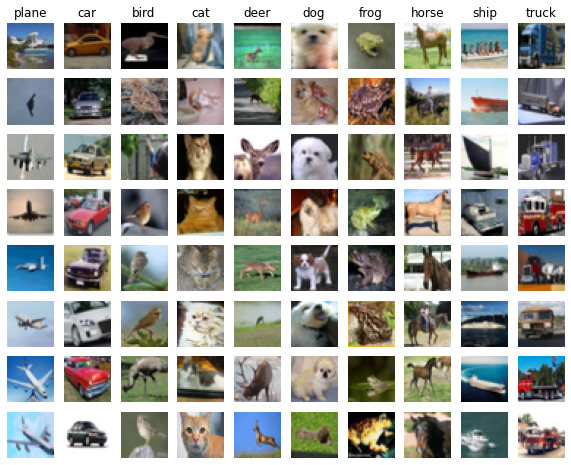

In [ ]:
plot_CIFAR_samples(X_train, y_train, LABEL_TRANSLATION, N=8)

### Подготовка данных 
**Нормализация значений на [0,1] и перевод целевой переменной в one-hot формат**

Аналогично задаче с датасетом **MNIST** нормализуем картинки (каждый пиксель представлен числом от $0$ до $255$) и переводим числа классов в **one-hot** вектора.

**One-hot encoding** преобразование можно выполнить функцией
 `keras.utils.to_categorical`, которая на вход принимает вектор с целевой переменной и общее число классов.

In [ ]:
X_train = X_train / 255 
X_test = X_test / 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [ ]:
y_train.shape

(50000, 10)

In [ ]:
y_test.shape

(10000, 10)

### Baseline


Построим сверточную нейросеть из нескольких блоков: **conv-conv-maxpool**. 

Эти блоки впервые появились в публикации [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556). В этой статье представлена архитектура **VGG**. В архитектуре LeNet в блоке был один сверточный слой и один слой пулинга.

**VGG** - семейство существующих архитектур нейросетей, которые демонстрируют одни из лучших результатов в задачах выделения признаков из картинок.



Зададим функцию, создающую модель нейросети из двух **VGG** блоков - **define_model**, где 
- **kernel_initializer** - способ инициализации начальных значений для весов ядра сверточного слоя нейросети
- **he_uniform** - специальное распределение, которое позволяет улучшить способности нейросети в сравнении с просто случайным распределением весов

Посмотрим на результаты классификации.

In [ ]:
def define_model():
  # Создаем пустую модель
  model = Sequential()

  #VGG1-блок
  # Начинаем со сверточных слоя, указывая тип активации на выходе из него,
  # способ заполнения краев (padding) и способ инициализации весов
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  # Здесь мы используем метод MaxPooling, который уменьшает размер обрабатываемого изображения, 
  # выбирая из 4 пикселей 1 с максимальным значением, чтобы это быстрее считалось. (2,2) -> 1
  model.add(MaxPooling2D((2, 2)))
  # Слой dropout, который на каждом шаге "выключает" 20% случайно выбранных нейронов
  model.add(Dropout(0.2))

  #VGG2-блок
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  # Разворачиваем данные в вектор
  model.add(Flatten())
  # Добавляем полносвязные слои:
  # ReLU активация скрытого слоя
  model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  # Знакомый нам softmax для выходного полносвязного слоя
  model.add(Dense(10, activation='softmax'))

  # Компилируем модель с функцией ошибки categorical crossentropy, оптимизатором Адам 
  # (оптимизатор, который со стандартным набором параметров может обучить эффективную
  # нейросеть), и метрикой - количеством правильно угаданных картинок.
  model.compile(loss='categorical_crossentropy',
                  optimizer = 'nadam',
                  metrics = ['accuracy'])
  return model

In [ ]:
# При помощи функции define_model строим последовательную сверточную нейросеть
base_model = define_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



При помощи `fit` натренируем нашу модель в $25$ эпох с размером батча $128$.

На выходе мы получим натренированную модель и структуру `vgg1_cnn`, 
из которой можно достать значения функции ошибки и метрик качества

In [ ]:
vgg1_cnn = base_model.fit(X_train, y_train,
              batch_size=128,
              epochs=25,
              validation_data=(X_test, y_test),
              shuffle=True)


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 267us/step - loss: 1.7914 - accuracy: 0.3466 - val_loss: 1.2981 - val_accuracy: 0.5410
Epoch 2/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.2749 - accuracy: 0.5443 - val_loss: 1.1062 - val_accuracy: 0.6027
Epoch 3/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.0607 - accuracy: 0.6251 - val_loss: 0.9105 - val_accuracy: 0.6833
Epoch 4/25
50000/50000 [==============================] - 6s 119us/step - loss: 0.9362 - accuracy: 0.6703 - val_loss: 0.8318 - val_accuracy: 0.7104
Epoch 5/25
50000/50000 [==============================] - 6s 117us/step - loss: 0.8511 - accuracy: 0.7011 - val_loss: 0.8427 - val_accuracy: 0.7068
Epoch 6/25
50000/50000 [==============================] - 6s 118us/step - loss: 0.7850 - accuracy: 0.7270 - val_loss: 0.7324 - val_accuracy: 0.7504
Epoch 7/25
50000/50000 [==============================] - 6s

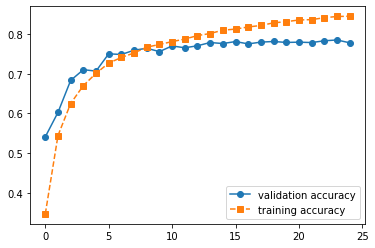

In [ ]:
# Построим графики точности на валидационной (val_accuracy) и обучающей (accuracy) выборках
# в конце каждой эпохи обучения

plt.plot(vgg1_cnn.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(vgg1_cnn.history['accuracy'], '--s', label='training accuracy')
plt.legend();

Точность на валидационной выборке (синяя линия) быстро сбавляет скорость роста и уступает точности на тренировочном датасете (оранжевая линия), так что мы немного переобучаемся, несмотря на слои **Dropout**.

In [ ]:
# Выведем метрики качества нашей нейросети (функцию ошибки и точность)
# для тестовой выборки

base_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 114us/step


[0.7087379233837128, 0.7781999707221985]

## Переобучение. Аугментация данных

Еще один способ решения проблемы переобучения сети - аугментация ("увеличение") тренировочного датасета без привлечения реальных новых картинок.
 
Попробуем изменять наши исходные картинки перед тем, как они попадут в сетку при помощи различных трансформаций.

Конечно, можно было бы поштучно изменить каждую картинку, сохранить, как новый датасет и тренировать модель уже на нем.

Но это дает меньшую вариативность преобразований, занимает много места и памяти. Чтобы не изменять каждую картинку вручную, используют генераторы.

Создадим такой генератор на основе наших данных при помощи модуля из `keras` библиотеки `ImageDataGenerator`.

### Генератор батчей с трансформацией

In [ ]:
# Импортируем нужный нам модель генератора
from keras.preprocessing.image import ImageDataGenerator

Более подробно о функциях генератора (предобработка изображений, в целом): https://keras.io/api/preprocessing/image/

Создадим экземпляр `ImageDataGenerator`, в качестве параметров укажем, какие изменения для картинок будем использовать. Таким образом, мы увеличиваем наш датасет, давая нейросети большую вариативность входных данных.

В данном случае:

**width_shift_range**=0.1 - случайный сдвиг изображение по горизонтали на 0.1 ширины;

**height_shift_range**=0.1 - случайный сдвиг изображение по вертикали на 0.1 высоты;

**horizontal_flip**=True - случайно отражает картинку по горизонтали

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

Применим полученные трансформации к нашим исходным данным.


Обратите внимание, что размер батча нужно указать здесь, чтобы генератор знал, 
сколько картинок ему выдавать модели при обучении.

Теперь при обращении к `train_generator` мы сможем получать измененные изображения.

При помощи метода `flow` получим генератор, связанный с нашими данными

In [ ]:
train_generator = datagen.flow(X_train, y_train, batch_size=128)

`train_generator` является итератором, т.е., чтобы получить батч элементов
нужно выполнить какую-то итерирующую функцию: например, цикл `for`.

In [ ]:
# Определим новую модель
gen_model = define_model()

In [ ]:
#  Обучим модель с данными из генератора при помощи .fit_generator,

# На выходе все так же мы получим натренированную модель и структуру vgg2_cnn, 
# из которой можно достать значения функции ошибки и метрик качества на обеих выборках
vgg2_cnn = gen_model.fit_generator(train_generator,
                        epochs=20,
                        validation_data=(X_test, y_test))

Epoch 1/20
391/391 [==============================] - 22s 56ms/step - loss: 1.9193 - accuracy: 0.2985 - val_loss: 1.4220 - val_accuracy: 0.4949
Epoch 2/20
391/391 [==============================] - 21s 54ms/step - loss: 1.4584 - accuracy: 0.4712 - val_loss: 1.2343 - val_accuracy: 0.5553
Epoch 3/20
391/391 [==============================] - 21s 53ms/step - loss: 1.2467 - accuracy: 0.5535 - val_loss: 0.9878 - val_accuracy: 0.6534
Epoch 4/20
391/391 [==============================] - 21s 54ms/step - loss: 1.1209 - accuracy: 0.6035 - val_loss: 0.9365 - val_accuracy: 0.6671
Epoch 5/20
391/391 [==============================] - 21s 54ms/step - loss: 1.0297 - accuracy: 0.6378 - val_loss: 0.8249 - val_accuracy: 0.7091
Epoch 6/20
391/391 [==============================] - 21s 54ms/step - loss: 0.9782 - accuracy: 0.6564 - val_loss: 0.8151 - val_accuracy: 0.7216
Epoch 7/20
391/391 [==============================] - 21s 55ms/step - loss: 0.9415 - accuracy: 0.6711 - val_loss: 0.8022 - val_accuracy:

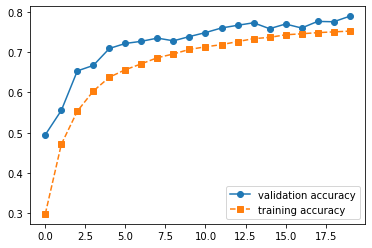

In [ ]:
# Построим графики точности на валидационной (val_accuracy) и обучающей (accuracy) выборках
# в конце каждой эпохи обучения

plt.plot(vgg2_cnn.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(vgg2_cnn.history['accuracy'], '--s', label='training accuracy')
plt.legend();

In [ ]:
gen_model.evaluate(X_test, y_test)


10000/10000 [==============================] - 1s 107us/step


[0.640858397245407, 0.7890999913215637]


Видно, что точность на валидационной выборке еще не вышла на "плато", а модель не успела переобучиться, значит, при увеличении числа эпох тренировки мы сможем еще увеличить нашу точность на валидационном наборе данных.

## 3) Немного практики

Попробуйте добавить другие трансформации в исходную выборку данных и обучить модель на еще более аугментированных данных.



Возможные трансформации даны далее, нужно поменять их параметры.

In [ ]:
my_datagen = ImageDataGenerator(
        rotation_range=0,  # Случайно повернуть картинку в диапазоне (0, degrees)
        # Возможные значения - число от 0 до 360 градусов

        width_shift_range=0.1, # Случайно подвинуть картинку по горизонтали на 0.1 ширины
        # Возможные значения - число от -1 до 1 (- влево, + вправо)
        height_shift_range=0.1,# Случайно подвинуть картинку по вертикали на 0.1 ширины
        # Возможные значения - число от -1 до 1 (- вниз, + вверх)
        
        shear_range=0,  # Установить случайный диапазон сдвига (деформация)
        # Угол сдвига по часовой стрелке в градусах от 0 до 360

        zoom_range=0.,  # Увеличение или уменьшение изображения в диапазоне [1-zoom_range,1+zoom_range]
        # от 0 до 1

        horizontal_flip=True,  # случайно отражать картинку по горизонтали
        # True/False
        vertical_flip=False  # случайно отражать картинку по вертикали
        # True/False
        )

In [ ]:
# Возможная конфигурация
my_datagen = ImageDataGenerator(
             rotation_range=15, 
             zoom_range = 0.2, 
             width_shift_range=0.1, 
             height_shift_range=0.2, 
             horizontal_flip=True, 
             zca_whitening=True)

In [ ]:
# Применим полученные трансформации к нашим исходным данным при помощи метода flow,
# и укажем размер батча

train_generator = my_datagen.flow(X_train, y_train, batch_size=128)

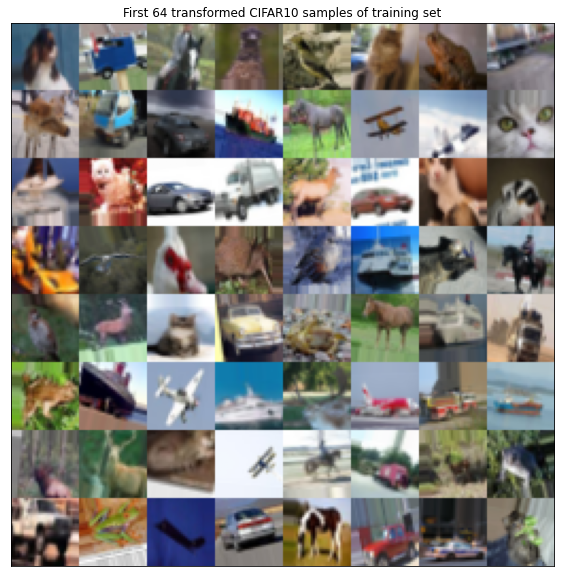

In [ ]:
# Итерирующий функцией, достанем из генератора батч картинок
for img in train_generator:
  img=img[0]
  break

# Построим 8х8 трансформированных элементов нашего датасета
# при помощи функции plot_dataset_samples_grid

plot_dataset_samples_grid(img, dataset_name='transformed CIFAR10', N=8)

In [ ]:
# Создадим новую модель нейросети
gen2_model = define_model()

In [ ]:
#  Обучим модель с аугментированными данными
#  Используем model.fit_generator,
#  который вместо X_train, y_train для тренировочной выборки
#  берет данные из генератора

# На выходе получим натренированную модель и структуру history_cnn, 
# из которой можно достать значения функции ошибки и метрик качества на обеих выборках
vgg3_cnn = gen2_model.fit_generator(train_generator,
                        epochs=25,
                        validation_data=(X_test, y_test)) 

Epoch 1/25
391/391 [==============================] - 24s 60ms/step - loss: 1.8886 - accuracy: 0.3027 - val_loss: 1.4183 - val_accuracy: 0.4853
Epoch 2/25
391/391 [==============================] - 23s 59ms/step - loss: 1.5342 - accuracy: 0.4424 - val_loss: 1.1934 - val_accuracy: 0.5718
Epoch 3/25
391/391 [==============================] - 23s 59ms/step - loss: 1.3792 - accuracy: 0.5003 - val_loss: 1.1131 - val_accuracy: 0.5973
Epoch 4/25
391/391 [==============================] - 23s 59ms/step - loss: 1.2794 - accuracy: 0.5391 - val_loss: 1.0570 - val_accuracy: 0.6244
Epoch 5/25
391/391 [==============================] - 23s 58ms/step - loss: 1.2121 - accuracy: 0.5662 - val_loss: 1.0103 - val_accuracy: 0.6438
Epoch 6/25
391/391 [==============================] - 24s 60ms/step - loss: 1.1538 - accuracy: 0.5877 - val_loss: 0.9632 - val_accuracy: 0.6618
Epoch 7/25
391/391 [==============================] - 23s 60ms/step - loss: 1.1141 - accuracy: 0.6048 - val_loss: 0.8560 - val_accuracy:

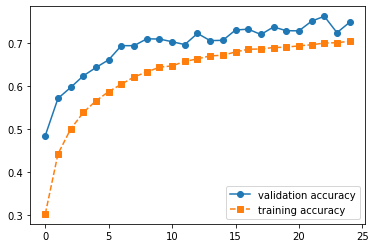

In [ ]:
# Построим графики точности на валидационной (val_accuracy) и обучающей (accuracy) выборках
# в конце каждой эпохи обучения

plt.plot(vgg3_cnn.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(vgg3_cnn.history['accuracy'], '--s', label='training accuracy')
plt.legend();

In [ ]:
# И посмотрим на финальный результат
gen2_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 113us/step


[0.7403281147003173, 0.7491999864578247]

В этом примере выбранные способы для аугментации не дали улучшения.

### Вывод

Аугментация тренировочной выборки положительно влияет на обобщающую способность сети, позволяя нейросети улавливать свойства целого класса, а не небольшой выборки тренировочных данных.

## 4) Cats vs Dogs



Теперь мы поработаем с датасетом, который не входит в набор стандартных датасетов библиотеки Keras, поэтому данные придется загружать из внешнего источника.

Загрузим датасет для бинарной классификации кошек и собак. Попробуем заставить нашу сеть ответить на вопрос: это кошки или собаки?




<table>
<tr>
<td>
<img src="https://preview.redd.it/4j8gx4ztzex01.png?width=960&crop=smart&auto=webp&s=5e80ab0071d56cc042f7b709648de8cde394832a" width="200">
</td>
<td>
</td>
</tr>
<tr>
<td>
<img src="https://cdn.images.express.co.uk/img/dynamic/128/590x/secondary/Viral-cat-sensation-715546.jpg" width="200">
</td>
<td>
<img src="https://www.sunnyskyz.com/uploads/2016/12/hmm9j-dog-or-cat-2.jpg" width="200">
</td>
</tr>
</table>



In [ ]:
# Импортируем функцию для загрузки картинок из файлов и генератор картинок
from keras.preprocessing.image import load_img, ImageDataGenerator

In [ ]:
import os

### Загрузка данных

In [ ]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip

--2021-02-08 12:06:00--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.206
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  79.0MB/s    in 7.5s    

2021-02-08 12:06:08 (73.8 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



Теперь наши данные хранятся в папке `Cat_Dog_data` с разделением на поддиректории `train` и `test`.

Элементы каждого класса хранятся в своей директории (`cat` или `dog`). 

In [ ]:
base_dir = 'Cat_Dog_data'

train_dir = os.path.join(base_dir, 'train')

test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Посмотрим, как именно расположены директории с датасетом относительно друг друга
tree(base_dir,print_files=False)

Cat_Dog_data/
|  test/
|  |  cat/
|  |  dog/
|  train/
|  |  cat/
|  |  dog/


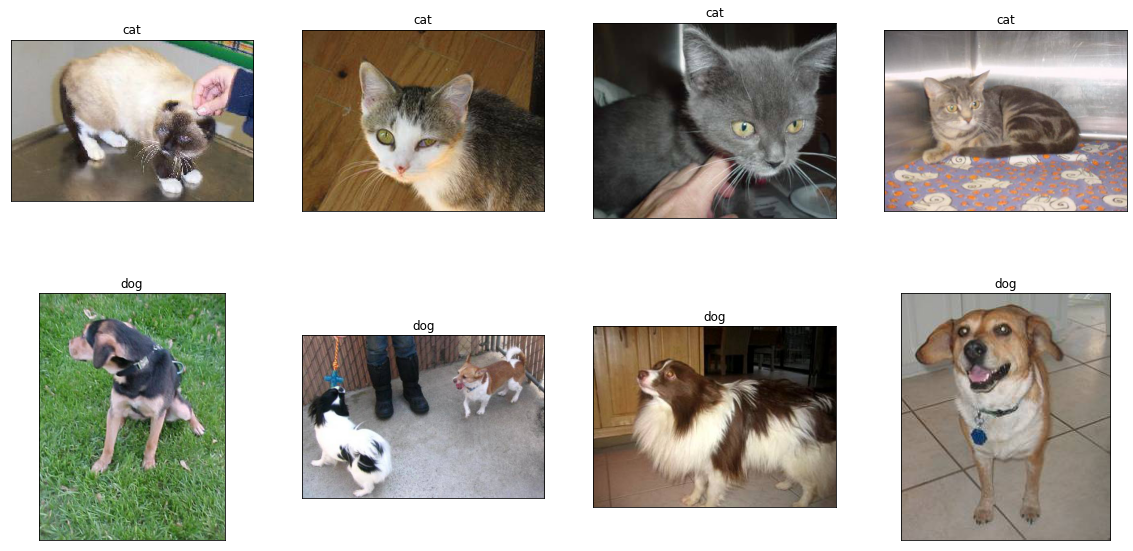

In [ ]:
#Посмотрим на содержание датасета при помощи функции plot_cats_dogs_samples
plot_cats_dogs_samples(train_dir, N=4)

### Подготовка данных 


Такой формат хранения удобен для использования функции генератора изображений `flow_from_directory`. 

Генератор не будет выкачивать все данные в оперативную память, а будет поочередно считывать из директорий нужные изображения и складывать их в батчи.

Создадим `ImageDataGenerator` для трейновой и тестовой выборок, поскольку обе выборки нужно доставать из директорий.

Укажем преобразование, нормализующее изображения 

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Зададим поток тренировочных батчей из директории **train** и **test**;

Приведем все изображения к одному квадратному формату;

Укажем, что работаем с задачей бинарной классификации

In [ ]:
#Теперь для создания генератора вместо метода flow мы пользуемся 
# flow_from_directory

train_generator = train_datagen.flow_from_directory(
        train_dir,  # Путь к директории с трейновой выборкой
        target_size=(150, 150),  # Размер изображений, к которому нужно привести все данные
        batch_size=128,
        #Генератор автоматически расставит бинарные лейблы для классов cat и dog
        class_mode='binary')


test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=128,
        class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [ ]:
# Соотношение между номером класса и его называнием запишем в словарь
LABEL_DICT={1:'dog',0:'cat'}

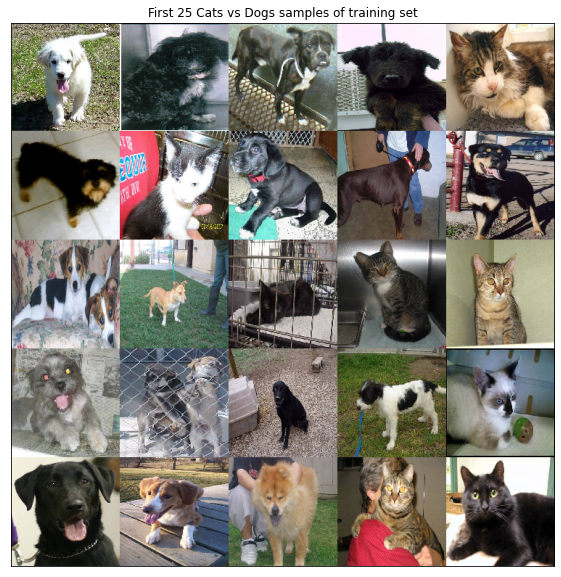

In [ ]:
# train_generator является итератором, т.е., чтобы получить батч элементов
# нужно выполнить какую-то итерирующую функцию: например, цикл for
for img in train_generator:
  img=img[0]
  break

#Посмотрим, какие у нас вышли картинки при помощи функции plot_dataset_samples_grid
plot_dataset_samples_grid(img,'Cats vs Dogs', N=5)

### 3. Baseline
Для сравнения построим небольшую  baseline сверточную модель, состоящую из трех блоков **conv-maxpool** и пары полносвязных слоев.



Размер входящего изображения `input_shape`=($150$, $150$, $3$). На выходе мы получим вероятность от $0$ до $1$, что картинка принадлежит к классу $1$ (**dog**).

In [ ]:
def define_model():
  # Создаем пустую модель
  model = Sequential()

#1й сверточный блок
  # Начинаем со сверточных слоя, указывая тип активации ReLU
  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
  # Здесь мы используем метод MaxPooling, который уменьшает размер обрабатываемого изображения, 
  # выбирая из 4 пикселей 1 с максимальным значением, чтобы это быстрее считалось. (2,2) -> 1
  model.add(MaxPooling2D((2, 2)))

#2й сверточный блок
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

#3й сверточный блок
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  # Разворачиваем данные в вектор
  model.add(Flatten())
  # Добавляем полносвязные слои:
  # ReLU активация скрытого слоя
  model.add(Dense(512, activation='relu'))
  # Sigmoid в качестве активации и одна выходная переменная - 
  # вероятность, что картинка принадлежит к классу 1
  model.add(Dense(1, activation='sigmoid'))


  # Компилируем модель с функцией ошибки binary crossentropy, оптимизатором Адам 
  # (оптимизатор, который со стандартным набором параметров может обучить эффективную
  # нейросеть), и метрикой - количеством правильно угаданных картинок.
  model.compile(loss='binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
  return model

In [ ]:
# Создаем новую модель
base_model = define_model()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
#Посмотрим, из чего наша модель состоит
base_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18496)            

In [ ]:
vgg3_cnn = base_model.fit_generator(
      train_generator,
      epochs=7,
      validation_data=test_generator)

Epoch 1/7
176/176 [==============================] - 65s 367ms/step - loss: 0.6404 - accuracy: 0.6519 - val_loss: 0.5194 - val_accuracy: 0.7224
Epoch 2/7
176/176 [==============================] - 61s 346ms/step - loss: 0.4893 - accuracy: 0.7644 - val_loss: 0.4357 - val_accuracy: 0.7588
Epoch 3/7
 93/176 [==============>...............] - ETA: 26s - loss: 0.4366 - accuracy: 0.7939

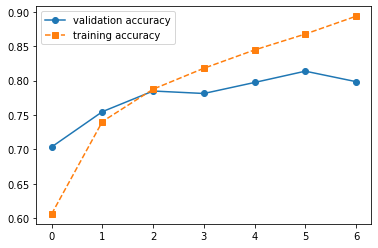

In [ ]:
# Построим графики точности на валидационной (val_accuracy) и обучающей (accuracy) выборках
# в конце каждой эпохи обучения

plt.plot(vgg3_cnn.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(vgg3_cnn.history['accuracy'], '--s', label='training accuracy')
plt.legend();

In [ ]:
# Взглянем на итоговые результаты классификации на тестовой выборке 
# (функция ошибки, точность)
base_model.evaluate(test_generator)

20/20 [==============================] - 6s 322ms/step


[0.3648969829082489, 0.7983999848365784]

Видно, что точность на тестовой выборке практически сразу вышла на плато около $0.8$, а точность на трейновой выборке почти достигла $1$

### 4. Evaluation на особенных картинках

Посмотрим, что скажет нейросеть по поводу наших особенных картинок

In [ ]:
# Загрузим картинки из описания задачи при помощи функции load_special_images()
im1, im2, im3 = load_special_images()

Изменим размер картинок на размер входных данных нейросети ($150$х$150$).

Добавим дополнительную размерность, поскольку сеть принимает картинки с еще одной размерностью батча. 

Все это делаем при помощи функции `image_to_batch`

In [ ]:
im1_150 = image_to_batch(im1, 150)
im2_150 = image_to_batch(im2, 150)
im3_150 = image_to_batch(im3, 150)

In [ ]:
im1_150.shape

(1, 150, 150, 3)

Заметим, что прежде, чем подавать картинки в нейросеть их нужно не забыть **отнормировать**!

In [ ]:
im1_150.max()

255

In [ ]:
im1_150 = im1_150/255.
im2_150 = im2_150/255.
im3_150 = im3_150/255.

Получим вероятности, что на картинках собаки, используя метод `predict`
нашей модели `base_model`

In [ ]:
pred1 = base_model.predict(im1_150)
pred2 = base_model.predict(im2_150)
pred3 = base_model.predict(im3_150)

In [ ]:
pred3

array([[0.3703653]], dtype=float32)

Посмотрим, для какой картинки какое предсказание дала нейросеть
при помощи функции `plot_special_images`

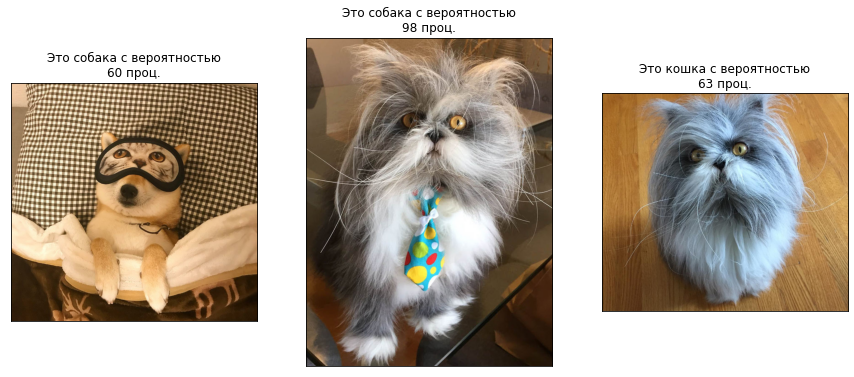

In [ ]:
plot_special_images(pred1,pred2,pred3)

## 5. Transfer learning

Использование предобученных моделей для новых задач

Как уже упоминалось ранее, есть архитектуры нейросетей, которые зарекомендовали себя в решении определенного класса задач, как, например, **VGG16**.

<img src="https://www.researchgate.net/profile/Max_Ferguson/publication/322512435/figure/download/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png" width="700">


**VGG16** и подобные ей модели содержат большое количество параметров и обучение их с нуля может занять большое количество времени. 

Кроме того, бывают задачи, где данных изначально небольшое количество и даже аугментация не сильно спасает положение, тогда обучение сверточной сети может не быть очень успешным.

Поэтому можно использовать модель, которая уже была кем-то предобучена, загрузить ее веса и дообучать только последние слои, подстраивая их под свою конкретную задачу.

#### План работы:

1.   Загрузить предобученную VGG16 модель без последних полносвязных слоев, отвечающих за конкретную задачу
2.   Построить свою полносвязную сеть для бинарной классификации кошек и собак
3.   Соединить две модели в одну.



### 1) Подготовим данные

Создадим `ImageDataGenerator` для трейновой и тестовой выборок,
указав преобразование, нормализующее изображения

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Изменим размеры картинок dataloader, поскольку модель **VGG16** принимает входные значения стандартизированного размера $224$х$224$x$3$.

Зададим поток тренировочных батчей из директории **train** и **test**.

Приведем все изображения к одному квадратному формату.

Укажем, что работаем с задачей бинарной классификации.

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # Путь к директории с трейновой выборкой
        target_size=(224, 224),  # Размер изображений, к которому нужно привести все данные
        batch_size=128,
        #Генератор автоматически расставит бинарные лейблы для классов cat и dog
        class_mode='binary')


test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=128,
        class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


### 2) Загрузим VGG16

В библиотеке `Keras` уже представлены архитектуры **State-of-the-art** моделей, поэтому можно достать **VGG16** модель одной строчкой кода.

In [ ]:
from keras.applications import vgg16 as vgg

Создадим **VGG** модель, в качестве параметра `weights` укажем `imagenet` - название
большого датасета с картинками, на котором сеть была натренирована;

`include_top` - False - не включать полносвязные слои вверху нейросети

In [ ]:
vgg_model = vgg.VGG16(weights='imagenet', 
                       include_top=False)

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
#Посмотрим, из чего состоит VGG модель
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Достанем последний слой `block5_pool` из **VGG** модели.

Сверху него мы далее построим наш классификатор.

In [ ]:
last = vgg_model.get_layer('block5_pool').output

## 6. Global Average Pooling, Batch Normalization

**Global Average Pooling (GAP)**

Вместо того, чтобы изпользовать слой **Flatten** между сверточными и полносвязными слоями, который просто превращает выходные данные из свертки в вектор, можно посчитать среднее число для каждого канала свернутого изображения и передать полученный вектор полносвязным слоям.

<img src="https://alexisbcook.github.io/assets/global_average_pooling.png" width="500">

**Batch Normalization**

Мы нормализуем входные данные нейросети, почему бы тогда не попробовать использовать нормализацию не только на входе, но и внутри модели?



### 3) Добавим небольшую нейросеть для бинарной классификации

In [ ]:
# Модуль, с помощью которого мы будем "сшивать" последовательные модели
from keras.engine import Model
# Импортируем Pooling по всему слою входных данных и нормализацию батчей
from keras.layers import GlobalAveragePooling2D, BatchNormalization

Добавим сверху слоя `last` **VGG** модели свои слои для классификации

In [ ]:
# Добавим новые GAP (вместо FLatten) и BatchNormalization слои
x = GlobalAveragePooling2D()(last)
x = BatchNormalization()(x)

# Привычные полносвязные слои
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(1, activation='sigmoid')(x)

Объединим **VGG16** и **классификатор** в одного трансформера при помощи модуля `Model`

In [ ]:
fin_model = Model(vgg_model.input, pred)

Теперь самое важное: нам не нужно изменять и так хорошо натренированные веса
исходной модели, поэтому мы **"замораживаем"** их, при тренировке они будут использоваться
только для вычисления выходных данных

In [ ]:
for layer in vgg_model.layers:
     layer.trainable = False

In [ ]:
# Скомпилируем модель с функцией ошибки binary crossentropy, оптимизатором Адам 
# (оптимизатор, который со стандартным набором параметров может обучить эффективную
# нейросеть), и метрикой - количеством правильно угаданных картинок.
fin_model.compile(loss='binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

In [ ]:
fin_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [ ]:
# Поставим модель обучаться 5 эпох при помощи модуля fit_generator
history_cnn = fin_model.fit_generator(train_generator,
              epochs=5,
              validation_data=test_generator,
              shuffle=True)

Epoch 1/5
176/176 [==============================] - 140s 794ms/step - loss: 0.1973 - accuracy: 0.9176 - val_loss: 0.2195 - val_accuracy: 0.9196
Epoch 2/5
176/176 [==============================] - 126s 715ms/step - loss: 0.1549 - accuracy: 0.9360 - val_loss: 0.1990 - val_accuracy: 0.9196
Epoch 3/5
176/176 [==============================] - 126s 716ms/step - loss: 0.1315 - accuracy: 0.9461 - val_loss: 0.0873 - val_accuracy: 0.9296
Epoch 4/5
176/176 [==============================] - 126s 714ms/step - loss: 0.1146 - accuracy: 0.9533 - val_loss: 0.2367 - val_accuracy: 0.9284
Epoch 5/5
176/176 [==============================] - 126s 714ms/step - loss: 0.0932 - accuracy: 0.9628 - val_loss: 0.1779 - val_accuracy: 0.9300


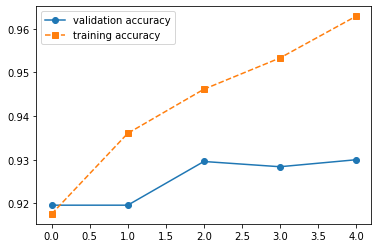

In [ ]:
plt.plot(history_cnn.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history_cnn.history['accuracy'], '--s', label='training accuracy')
plt.legend();

In [ ]:
fin_model.evaluate(test_generator)

20/20 [==============================] - 13s 642ms/step


[0.13731512427330017, 0.9300000071525574]

Использование предобученной модели **VGG** уже с 1й эпохи позволило нейросети достичь точности $>90$% на тестовой выборке!

Хотя и здесь изменение точности вышло на плато, текущий результат сильно превосходит бейзлайн и позволяет на его основе строить еще более мощные предсказательные модели.

### 4) Посмотрим результаты на особенных картинках

Изменим размер как у входных данных сети ($224х224$) и добавим дополнительную размерность при помощи функции `image_to_batch`

In [ ]:
im1_224=image_to_batch(im1,224)
im2_224=image_to_batch(im2,224)
im3_224=image_to_batch(im3,224)

Не забудем про нормировку!

In [ ]:
im1_224 = im1_224/255.
im2_224 = im2_224/255.
im3_224 = im2_224/255.

Получим вероятности, что на картинках собаки (используйте метод `predict`)


In [ ]:
pred1 = fin_model.predict(im1_224)
pred2 = fin_model.predict(im2_224)
pred3 = fin_model.predict(im3_224)

Посмотрим, для какой картинки какое предсказание дала нейросеть при помощи функции `plot_special_images`

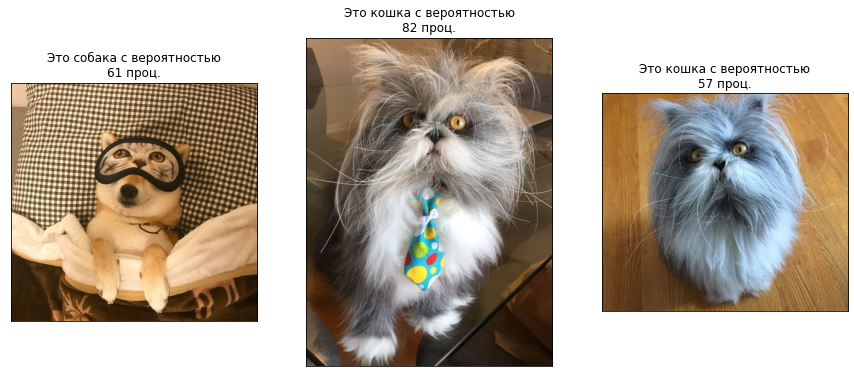

In [ ]:
plot_special_images(pred1,pred2,pred3)

Как видно, несмотря на то, что нейросеть в целом хорошо "понимает" устройство основной выборки кошек и собак, особые случаи ей ясны уже не так хорошо) Хотя модель поняла, что в центре кошка, собаку с кошачьими глазами она перепутала с котом.

### 5) Посмотрим на картинки с наибольшей ошибкой (Бонус) 


Найдем все предсказания на тестовой выборке и посмотрим, на каких картинках нейросеть
ошиблась больше всего.

In [ ]:
# Создадим генератор картинок из тестовой выборки
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=200,
        class_mode='binary',shuffle=False)

Found 2500 images belonging to 2 classes.


In [ ]:
preds_labels, preds_vec, labels_vec, datas_vec = get_test_predictions(test_generator, fin_model)

Найдем вектор ошибок, который для каждого предсказания `preds_labels[i]` 
будет содержать значение **True**, если модель ошиблась и **False**, если угадала `labels_vec[i]` верно.


In [ ]:
errors = labels_vec!=preds_labels

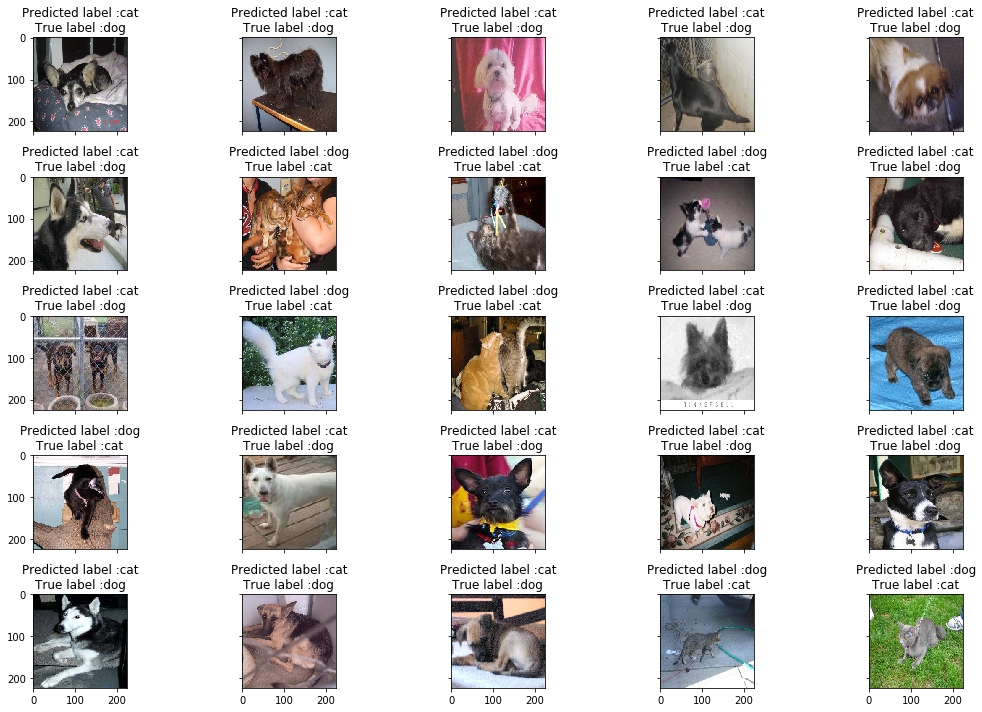

In [ ]:
# Выделим из векторов предсказаний и настоящих лейблов только те,
# где нейросеть допустила ошибку
Y_pred_classes_errors = preds_labels[errors]
Y_pred_errors = preds_vec[errors]
Y_true_errors = labels_vec[errors]
X_val_errors = datas_vec[errors]

# Вероятности неправильно предсказанных классов
Y_pred_errors_prob = Y_pred_errors

# Вероятности, соответствующие правильным классам
true_prob_errors = 1-Y_pred_errors

# Разница вероятностей правильного и неправильного классов
delta_pred_true_errors = np.abs(Y_pred_errors_prob - true_prob_errors)

# Отсортированный списоц разниц вероятностей
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# 25 наибольших ошибок
most_important_errors = sorted_dela_errors[-25:]

# Построим самые ошибочные rfhnbyrb
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## Выводы





1.   Мы обучили сверточную нейросеть на датасете из цветных фото из $10$ классов - **CIFAR10**

2.   Познакомились с различными видами трансформаций картинок, которые можно применять к своим данным при помощи генератора батчей - **`ImageDataGenerator()`**

3. Использовали **аугментированные** генератором данные для преодоления переобучения модели

4.  Научились работать не только с встроенными датасетами `keras`, но и загрузили новый датасет для **бинарной** классификации **Cats vs Dogs**

5.  Познакомились со **state-of-the-art** моделью для вытаскивания признаков из картинок - **VGG16**

6. Использовали новые слои нейронных сетей - **GlobalAveragePooling** и **BatchNormalization**

6. Узнали, что такое **transfer learning**, использовали предобученную **VGG16** модель для создания своего классификатора, достигли точности $>90$% на тестовой выборке с $1$й эпохи

## Дополнительное задание

1.   Аугментация данных
2.   Увеличение числа обучаемых параметров

#### 1) Улучшить модель

Попробовать улучшить предсказания при помощи 

1.   Aугментации исходных данных (Добавить в ImageDataGenerator различные трансформации)
2.   Увеличения числа обучаемых параметров.

Чем ближе слои модели к выходному слою, тем больше веса зависят от конкретной задачи.

Изначально мы заморозили все слои модели `vgg_model`, теперь можно заморозить, например, первые $15$ слоев, а остальные сделать обучаемыми.



##### Аугментация данных

Создадим ImageDataGenerator для трейновой и тестовой выборок,
указав преобразование, нормализующее изображения и еще какой-нибудь набор трансформаций из списка

На основе train_datagen и test_datagen сделаем генератор, создающий батчи
картинок из директорий с датасетом (`flow_from_directory`)

##### Замороженные веса

План по созданию новой модели на основе предобученной **VGG16** с **частью** замороженных весов


1.   Загрузим модель **vgg16** с весами 
2.   Построим сверху свой классификатор (можно скопировать тот, что мы использовали в предыдущей модели)
3.   Заморозим **ЧАСТЬ** весов модели
4.   Скомпилируем модель


Запустим обучение полученной модели с нашими генераторами 
с дополнительными трансформациями.

Обратите внимание, что за счет того, что у нас увеличилось количество тренируемых параметров и добавились трансформации, процесс тренировки ощутимо замедлился, за все в жизни надо платить :(

#### 2) Проверить поведение модели на особенных случаях